In [1]:
import torch
import torch.nn as nn
import numpy as np
from tc.tc_fc import TTLinear
import matplotlib.pyplot as plt
import time

from torch.nn.utils import parameters_to_vector

from matplotlib import cm

In [2]:
device = 'cuda'

**Utils**

In [13]:
# Function for computing derivatives
def nn_autograd_simple(model, points, order,axis=0):
    points.requires_grad=True
    f = model(points).sum()
    for i in range(order):
        grads, = torch.autograd.grad(f, points, create_graph=True)
        f = grads[:,axis].sum()
    return grads[:,axis]

def draw_fig(model, grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = grid[:, 0].detach().cpu().numpy().reshape(-1)
    ys = grid[:, 1].detach().cpu().numpy().reshape(-1)
    zs = model(grid).detach().cpu().numpy().reshape(-1)

    ax.plot_trisurf(xs, ys, zs, cmap=cm.jet, linewidth=0.2, alpha=1)

    ax.set_title("wave periodic")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")

    plt.show()

**Grid**

In [14]:
x = torch.linspace(0, 1, 51)
t = torch.linspace(0, 1, 51)

grid = torch.cartesian_prod(x, t).float().to(device)

**Boundary and initial conditions**

In [18]:
func_bnd1 = lambda x: 10 ** 4 * torch.sin((1 / 10) * x * (x - 1)) ** 2
bnd1 = torch.cartesian_prod(x, torch.tensor([0.])).float().to(device)
bndval1 = func_bnd1(bnd1[:, 0])

# du/dx (x,0) = 1e3*sin^2(x(x-1)/10)
func_bnd2 = lambda x: 10 ** 3 * torch.sin((1 / 10) * x * (x - 1)) ** 2
bnd2 = torch.cartesian_prod(x,  torch.tensor([0.])).float().to(device)
bndval2 = func_bnd2(bnd2[:, 0])

# u(0,t) = u(1,t)
bnd3_left = torch.cartesian_prod(torch.tensor([0.]), t).float().to(device)
bnd3_right = torch.cartesian_prod(torch.tensor([1.]), t).float().to(device)
bnd3 = [bnd3_left, bnd3_right]

# du/dt(0,t) = du/dt(1,t)
bnd4_left = torch.cartesian_prod(torch.tensor([0.]), t).float().to(device)
bnd4_right = torch.cartesian_prod(torch.tensor([1.]), t).float().to(device)
bnd4 = [bnd4_left, bnd4_right]

**Equation and losses**

In [22]:
def wave_op(model, grid):
    u_xx = nn_autograd_simple(model, grid, order=2, axis=0)
    u_tt = nn_autograd_simple(model, grid, order=2, axis=1)
    a = -(1 / 4)

    op = u_tt + a * u_xx

    return op

def op_loss(operator):
    return torch.mean(torch.square(operator))

def bcs_loss(model):
    bc1 = model(bnd1)
    bc2 = nn_autograd_simple(model, bnd2, order=1, axis=1)
    bc3 = model(bnd3_left) - model(bnd3_right)
    bc4 = nn_autograd_simple(model, bnd4_left, order=1, axis=0) - nn_autograd_simple(model, bnd4_right, order=1, axis=0)
    
    loss_bc1 = torch.mean(torch.square(bc1.reshape(-1) - bndval1))
    loss_bc2 = torch.mean(torch.square(bc2.reshape(-1) - bndval2))
    loss_bc3 = torch.mean(torch.square(bc3))
    loss_bc4 = torch.mean(torch.square(bc4))
    
    loss = loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4
    return loss

def loss_fn(model):
    operator = wave_op(model, grid)
    loss = op_loss(operator) + 1000 * bcs_loss(model)
    return loss

In [23]:
hid = [5, 2, 5, 2]
rank = [1, 2, 2, 2, 1]

# Combination of default linear layers and tt-layers
model = torch.nn.Sequential(
        nn.Linear(2, 100), 
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        nn.Linear(100, 1)).to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
for i in range(5001):
    optim.zero_grad()
    loss = loss_fn(model)
    loss.backward()
    if i % 500 == 0:
        print(f"iter: {i}, loss: {loss.item()}")
    optim.step()

iter: 0, loss: 97.2965087890625
iter: 500, loss: 119.84758758544922
iter: 1000, loss: 142.85755920410156
iter: 1500, loss: 71.9028549194336
iter: 2000, loss: 100.99501037597656
iter: 2500, loss: 85.16983032226562
iter: 3000, loss: 83.13876342773438
iter: 3500, loss: 81.6922836303711
iter: 4000, loss: 128.4600372314453
iter: 4500, loss: 86.74909210205078
iter: 5000, loss: 72.68294525146484


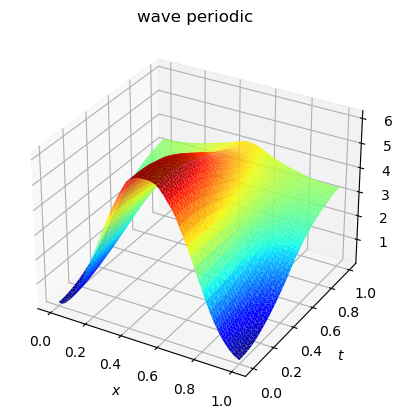

In [27]:
draw_fig(model, grid)